###  importing relevant libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
from numpy import array
from random import random
from sklearn import metrics
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB#57
from sklearn.naive_bayes import GaussianNB#52
from sklearn.naive_bayes import MultinomialNB#56
from sklearn.naive_bayes import CategoricalNB

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
import csv
import math
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn
import time



### Discovering Labels

In [3]:
def target_name(name):
    df = pd.read_csv(name,usecols=["Label"])
    target_names=sorted(list(df["Label"].unique()))
    return target_names

In [4]:
def folder(f_name): #this function creates a folder.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("Tthe folder could not be created!")

In [5]:
def find_the_way(path,file_format):
    files_add = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                files_add.append(os.path.join(r, file))  
    return files_add

In [6]:
altime=0
#def most_frequent(List): 
#    return max(set(List), key = List.count) 


 
def most_frequent(List):
    occurence_count = Counter(List)
    occurence_count={k: v for k, v in sorted(occurence_count.items(), key=lambda item: item[1],reverse=True)}
    big=list(occurence_count.values())
    big=big.count(big[0])
    return list(occurence_count.keys())[np.random.randint(big)]


def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))
def create_exception(df): 
    exception_list=[]
    dominant_mac=[]
    for i in df['aggregated'].unique():
        k=df[df['aggregated']==i]
        for ii in ['MAC']:
            hist = {}
            for x in k[ii].values:
                hist[x] = hist.get(x, 0) + 1
            hist=dict(sorted(hist.items(), key=lambda item: item[1],reverse=True))
            temp=next(iter(hist))
            if temp not in dominant_mac:
                dominant_mac.append(temp)
            else:
                exception_list.append(temp)
    return exception_list




def merged(m_test,predict,step,mixed):
    second=time.time()
    mac_test=[]
    for q in m_test.index:
        mac_test.append(m_test[q])

    d_list=sorted(list(m_test.unique()))
    devices={}
    for q in d_list:
        devices[q]=[]    


    new_y=[0]*len(m_test)

    for q,qq in enumerate (mac_test):
        devices[qq].append(q)
    for q in devices:
        a = [devices[q][j:j + step] for j in range(0, len(devices[q]), step)]  
        for qq in a:
            step_list=[]
            for qqq in qq:
                step_list.append(predict[qqq])
            add=most_frequent(list(step_list))
            for qqq in qq:
                new_y[qqq]=add
    results=pd.DataFrame(m_test)
    results["aggregated"]=new_y
    results["normal"]=predict
    
    #MIXED METHOD
    if mixed:
        exception=create_exception(results)
        for q in exception:
            results.loc[results.MAC == q, 'aggregated'] = results['normal']

    return results["aggregated"].values,time.time()-second

## Calculation of evaluations

In [7]:
def score(altime,train_time,test_time,predict,y_test,class_based_results,i,cv,dname,ii):
    precision=[]
    recall=[]
    f1=[]
    accuracy=[]
    total_time=[]
    kappa=[]
    accuracy_b=[]
    
    rc=sklearn.metrics.recall_score(y_test, predict,average= "macro")
    pr=sklearn.metrics.precision_score(y_test, predict,average= "macro")
    f_1=sklearn.metrics.f1_score(y_test, predict,average= "macro")        
    report = classification_report(y_test, predict, target_names=target_names,output_dict=True)
    cr = pd.DataFrame(report).transpose()
    if class_based_results.empty:
        class_based_results =cr
    else:
        class_based_results = class_based_results.add(cr, fill_value=0)
    precision.append(float(pr))
    recall.append(float(rc))
    f1.append(float(f_1))
    accuracy_b.append(balanced_accuracy_score( y_test,predict))
    accuracy.append(accuracy_score(y_test, predict))

    kappa.append(round(float(sklearn.metrics.cohen_kappa_score(y_test, predict, 
    labels=None, weights=None, sample_weight=None)),15))
    print ('%-15s %-3s %-3s %-6s  %-5s %-5s %-5s %-5s %-8s %-5s %-8s %-8s%-8s%-8s' % (dname,i,cv,ii[0:6],str(round(np.mean(accuracy),2)),str(round(np.mean(accuracy_b),2)),
        str(round(np.mean(precision),2)), str(round(np.mean(recall),2)),str(round(np.mean(f1),4)), 
        str(round(np.mean(kappa),2)),str(round(np.mean(train_time),2)),str(round(np.mean(test_time),2)),str(round(np.mean(test_time)+np.mean(train_time),2)),str(round(np.mean(altime),2))))
    lines=(str(dname)+","+str(i)+","+str(cv)+","+str(ii)+","+str(round(np.mean(accuracy),15))+","+str(round(np.mean(accuracy_b),15))+","+str(round(np.mean(precision),15))+","+ str(round(np.mean(recall),15))+","+str(round(np.mean(f1),15))+","+str(round(np.mean(kappa),15))+","+str(round(np.mean(train_time),15))+","+str(round(np.mean(test_time),15))+","+str(altime)+"\n")
    return lines,class_based_results

In [8]:
def ML(loop1,loop2,output_csv,cols,step,mixed,dname):

    ths = open(output_csv, "w")
    ths.write("Dataset,T,CV,ML algorithm,Acc,b_Acc,Precision, Recall , F1-score, kappa ,tra-Time,test-Time,Al-Time\n")
    

    from sklearn.metrics import balanced_accuracy_score
    from sklearn.preprocessing import Normalizer
    
    for ii in ml_list:
        print ('%-15s %-3s %-3s %-6s  %-5s %-5s %-5s %-5s %-8s %-5s %-8s %-8s%-8s%-8s'%
               ("Dataset","T","CV","ML alg","Acc","b_Acc","Prec", "Rec" , "F1", "kap" ,"tra-T","test-T","total","al-time"))
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        if ii in ["GB","SVM"]: #for slow algorithms.
            repetition=10 
        else:
            repetition=100
        for i in range(repetition):



            #TRAIN
            df = pd.read_csv(loop1,usecols=cols)
            m_train=df["MAC"]
            del df["MAC"]
            X_train =df[df.columns[0:-1]]
            X_train=np.array(X_train)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_train=df[df.columns[-1]].cat.codes  

            #TEST
            df = pd.read_csv(loop2,usecols=cols)
            df = shuffle(df, random_state=42)
            m_test=df["MAC"]
            del df["MAC"]
            X_test =df[df.columns[0:-1]]
            X_test=np.array(X_test)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_test=df[df.columns[-1]].cat.codes




            results_y=[]
            cv+=1
            results_y.append(y_test)


     
   

            #machine learning algorithm is applied in this section
            clf = ml_list[ii]#choose algorithm from ml_list dictionary
            second=time.time()
            clf.fit(X_train, y_train)
            train_time=(float((time.time()-second)) )
            second=time.time()
            predict =clf.predict(X_test)
            test_time=(float((time.time()-second)) )
            if step==1:
                altime=0
                lines,class_based_results=score(altime,train_time,test_time,predict,y_test,class_based_results,i,cv,dname,ii)
            else:
                predict,altime=merged(m_test,predict,step,mixed)
                lines,class_based_results=score(altime,train_time,test_time,predict,y_test,class_based_results,i,cv,dname,ii)
            ths.write (lines)


            df_cm = pd.DataFrame(confusion_matrix(y_test, predict))
            if cm.empty:
                cm =df_cm
            else:
                cm = cm.add(df_cm, fill_value=0)
            
        class_based_results=class_based_results/repetition
        print(class_based_results)
        class_based_results.to_csv("class_based_results.csv")
        if True:
            cm=cm//repetition
            graph_name=output_csv+ii+"_confusion matrix.pdf"   
            plt.figure(figsize = (40,28))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            plt.show()
            #print(cm)
            print("\n\n\n")             


            
            
            
            
            
            
            


    ths.close()  

# Machine learning applications 

# Aalto Dataset

In [9]:
feature= ['pck_size', 'Ether_type', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'IP_ihl', 'IP_tos', 'IP_len', 'IP_flags', 'IP_DF', 'IP_ttl', 'IP_options', 'ICMP_code', 'TCP_dataofs', 'TCP_FIN', 'TCP_ACK', 'TCP_window', 'UDP_len', 'DHCP_options', 'BOOTP_hlen', 'BOOTP_flags', 'BOOTP_sname', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_rd', 'DNS_qdcount', 'dport_class', 'payload_bytes', 'entropy',
"MAC",
'Label']


In [10]:
ml_list={"DT" :DecisionTreeClassifier(criterion='gini', max_depth=26.0,
                       max_features=26,min_samples_split= 6)}
dataset="./Aalto/"
folder(dataset)


# Normal Results

Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
Aalto/False_1   0   1   DT      0.71  0.71  0.78  0.71  0.7282   0.68  0.5      0.03    0.53    0.0     
Aalto/False_1   1   2   DT      0.71  0.71  0.77  0.71  0.7274   0.68  0.15     0.01    0.16    0.0     
Aalto/False_1   2   3   DT      0.71  0.71  0.77  0.71  0.7256   0.68  0.17     0.01    0.17    0.0     
Aalto/False_1   3   4   DT      0.7   0.71  0.77  0.71  0.7256   0.68  0.15     0.01    0.16    0.0     
Aalto/False_1   4   5   DT      0.71  0.71  0.78  0.71  0.7281   0.68  0.15     0.01    0.16    0.0     
Aalto/False_1   5   6   DT      0.71  0.71  0.78  0.71  0.7278   0.68  0.17     0.01    0.18    0.0     
Aalto/False_1   6   7   DT      0.71  0.71  0.77  0.71  0.7264   0.68  0.16     0.01    0.17    0.0     
Aalto/False_1   7   8   DT      0.71  0.71  0.78  0.71  0.7281   0.68  0.16     0.01    0.16    0.0     
Aalto/False_1   8   9   DT      0.71  0.71  0.77  0.71 

Aalto/False_1   78  79  DT      0.71  0.71  0.78  0.71  0.7286   0.68  0.19     0.01    0.19    0.0     
Aalto/False_1   79  80  DT      0.7   0.71  0.77  0.71  0.7268   0.68  0.17     0.01    0.17    0.0     
Aalto/False_1   80  81  DT      0.7   0.71  0.77  0.71  0.7268   0.67  0.18     0.01    0.18    0.0     
Aalto/False_1   81  82  DT      0.71  0.71  0.78  0.71  0.7282   0.68  0.17     0.01    0.18    0.0     
Aalto/False_1   82  83  DT      0.71  0.71  0.78  0.71  0.7273   0.68  0.19     0.01    0.19    0.0     
Aalto/False_1   83  84  DT      0.71  0.7   0.77  0.7   0.7254   0.68  0.15     0.01    0.16    0.0     
Aalto/False_1   84  85  DT      0.71  0.71  0.78  0.71  0.7277   0.68  0.18     0.01    0.19    0.0     
Aalto/False_1   85  86  DT      0.7   0.7   0.77  0.7   0.7265   0.68  0.16     0.01    0.17    0.0     
Aalto/False_1   86  87  DT      0.71  0.71  0.77  0.71  0.7259   0.68  0.25     0.01    0.25    0.0     
Aalto/False_1   87  88  DT      0.7   0.71  0.78  0.71 

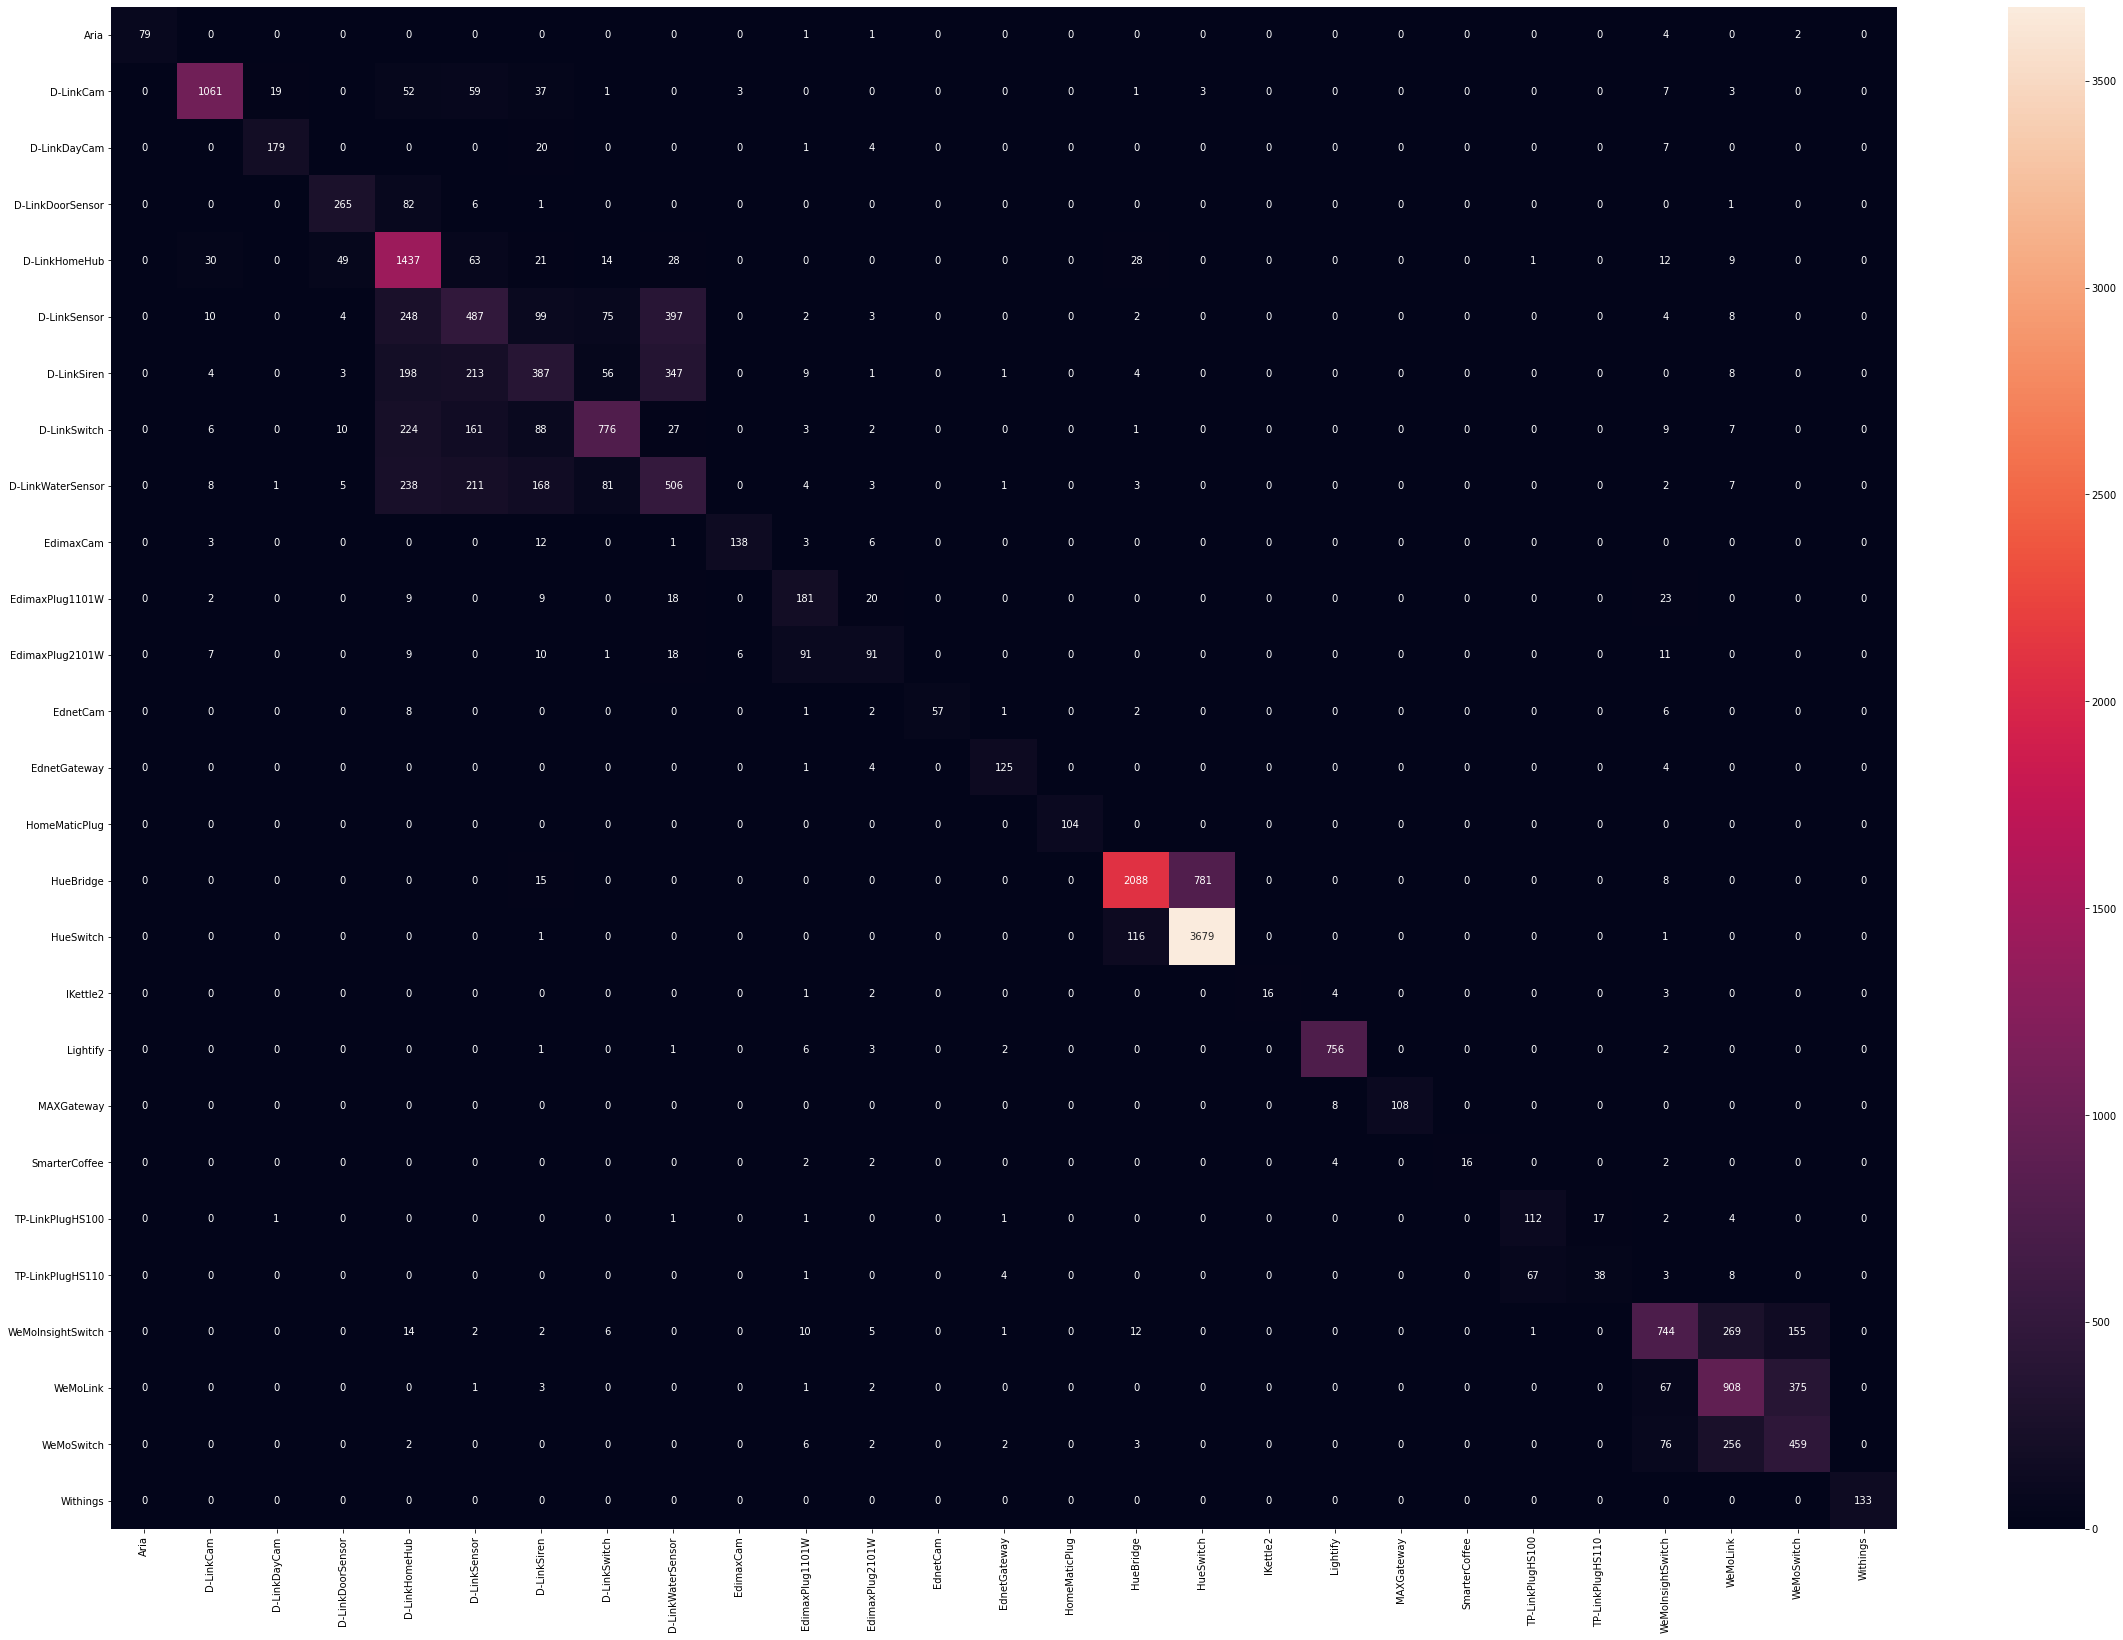

In [12]:
test='Aalto_test_IoTDevID.csv'
train='Aalto_train_IoTDevID.csv'



dataset="./Aalto/False/"
folder(dataset)

mixed=False
step=1
sayac=1
output_csv=dataset+str(sayac)+"_"+str(step)+"_"+str(mixed)+".csv"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step))   


# Aggregated Results (Size 13)

Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
Aalto/False_13  0   1   DT      0.75  0.82  0.87  0.82  0.8099   0.72  0.23     0.01    0.23    0.14    
Aalto/False_13  1   2   DT      0.75  0.82  0.87  0.82  0.8115   0.72  0.19     0.01    0.2     0.21    
Aalto/False_13  2   3   DT      0.75  0.82  0.87  0.82  0.8108   0.73  0.19     0.01    0.2     0.14    
Aalto/False_13  3   4   DT      0.75  0.82  0.87  0.82  0.8118   0.72  0.29     0.01    0.3     0.16    
Aalto/False_13  4   5   DT      0.74  0.82  0.87  0.82  0.8047   0.72  0.27     0.01    0.28    0.26    
Aalto/False_13  5   6   DT      0.74  0.82  0.87  0.82  0.81     0.72  0.31     0.01    0.32    0.33    
Aalto/False_13  6   7   DT      0.74  0.82  0.86  0.82  0.8088   0.72  0.28     0.01    0.29    0.28    
Aalto/False_13  7   8   DT      0.75  0.82  0.86  0.82  0.8043   0.72  0.29     0.01    0.3     0.22    
Aalto/False_13  8   9   DT      0.75  0.83  0.87  0.83 

Aalto/False_13  78  79  DT      0.75  0.83  0.87  0.83  0.8139   0.72  0.21     0.01    0.22    0.14    
Aalto/False_13  79  80  DT      0.75  0.82  0.87  0.82  0.8111   0.72  0.2      0.01    0.2     0.16    
Aalto/False_13  80  81  DT      0.75  0.82  0.87  0.82  0.8134   0.72  0.2      0.01    0.2     0.14    
Aalto/False_13  81  82  DT      0.74  0.82  0.87  0.82  0.8083   0.72  0.21     0.01    0.21    0.16    
Aalto/False_13  82  83  DT      0.75  0.82  0.87  0.82  0.8129   0.72  0.22     0.01    0.23    0.14    
Aalto/False_13  83  84  DT      0.74  0.82  0.87  0.82  0.8042   0.72  0.21     0.01    0.22    0.17    
Aalto/False_13  84  85  DT      0.75  0.82  0.87  0.82  0.8065   0.72  0.2      0.01    0.21    0.18    
Aalto/False_13  85  86  DT      0.75  0.82  0.87  0.82  0.8144   0.72  0.2      0.01    0.21    0.15    
Aalto/False_13  86  87  DT      0.75  0.82  0.87  0.82  0.8038   0.72  0.2      0.01    0.21    0.16    
Aalto/False_13  87  88  DT      0.75  0.82  0.87  0.82 

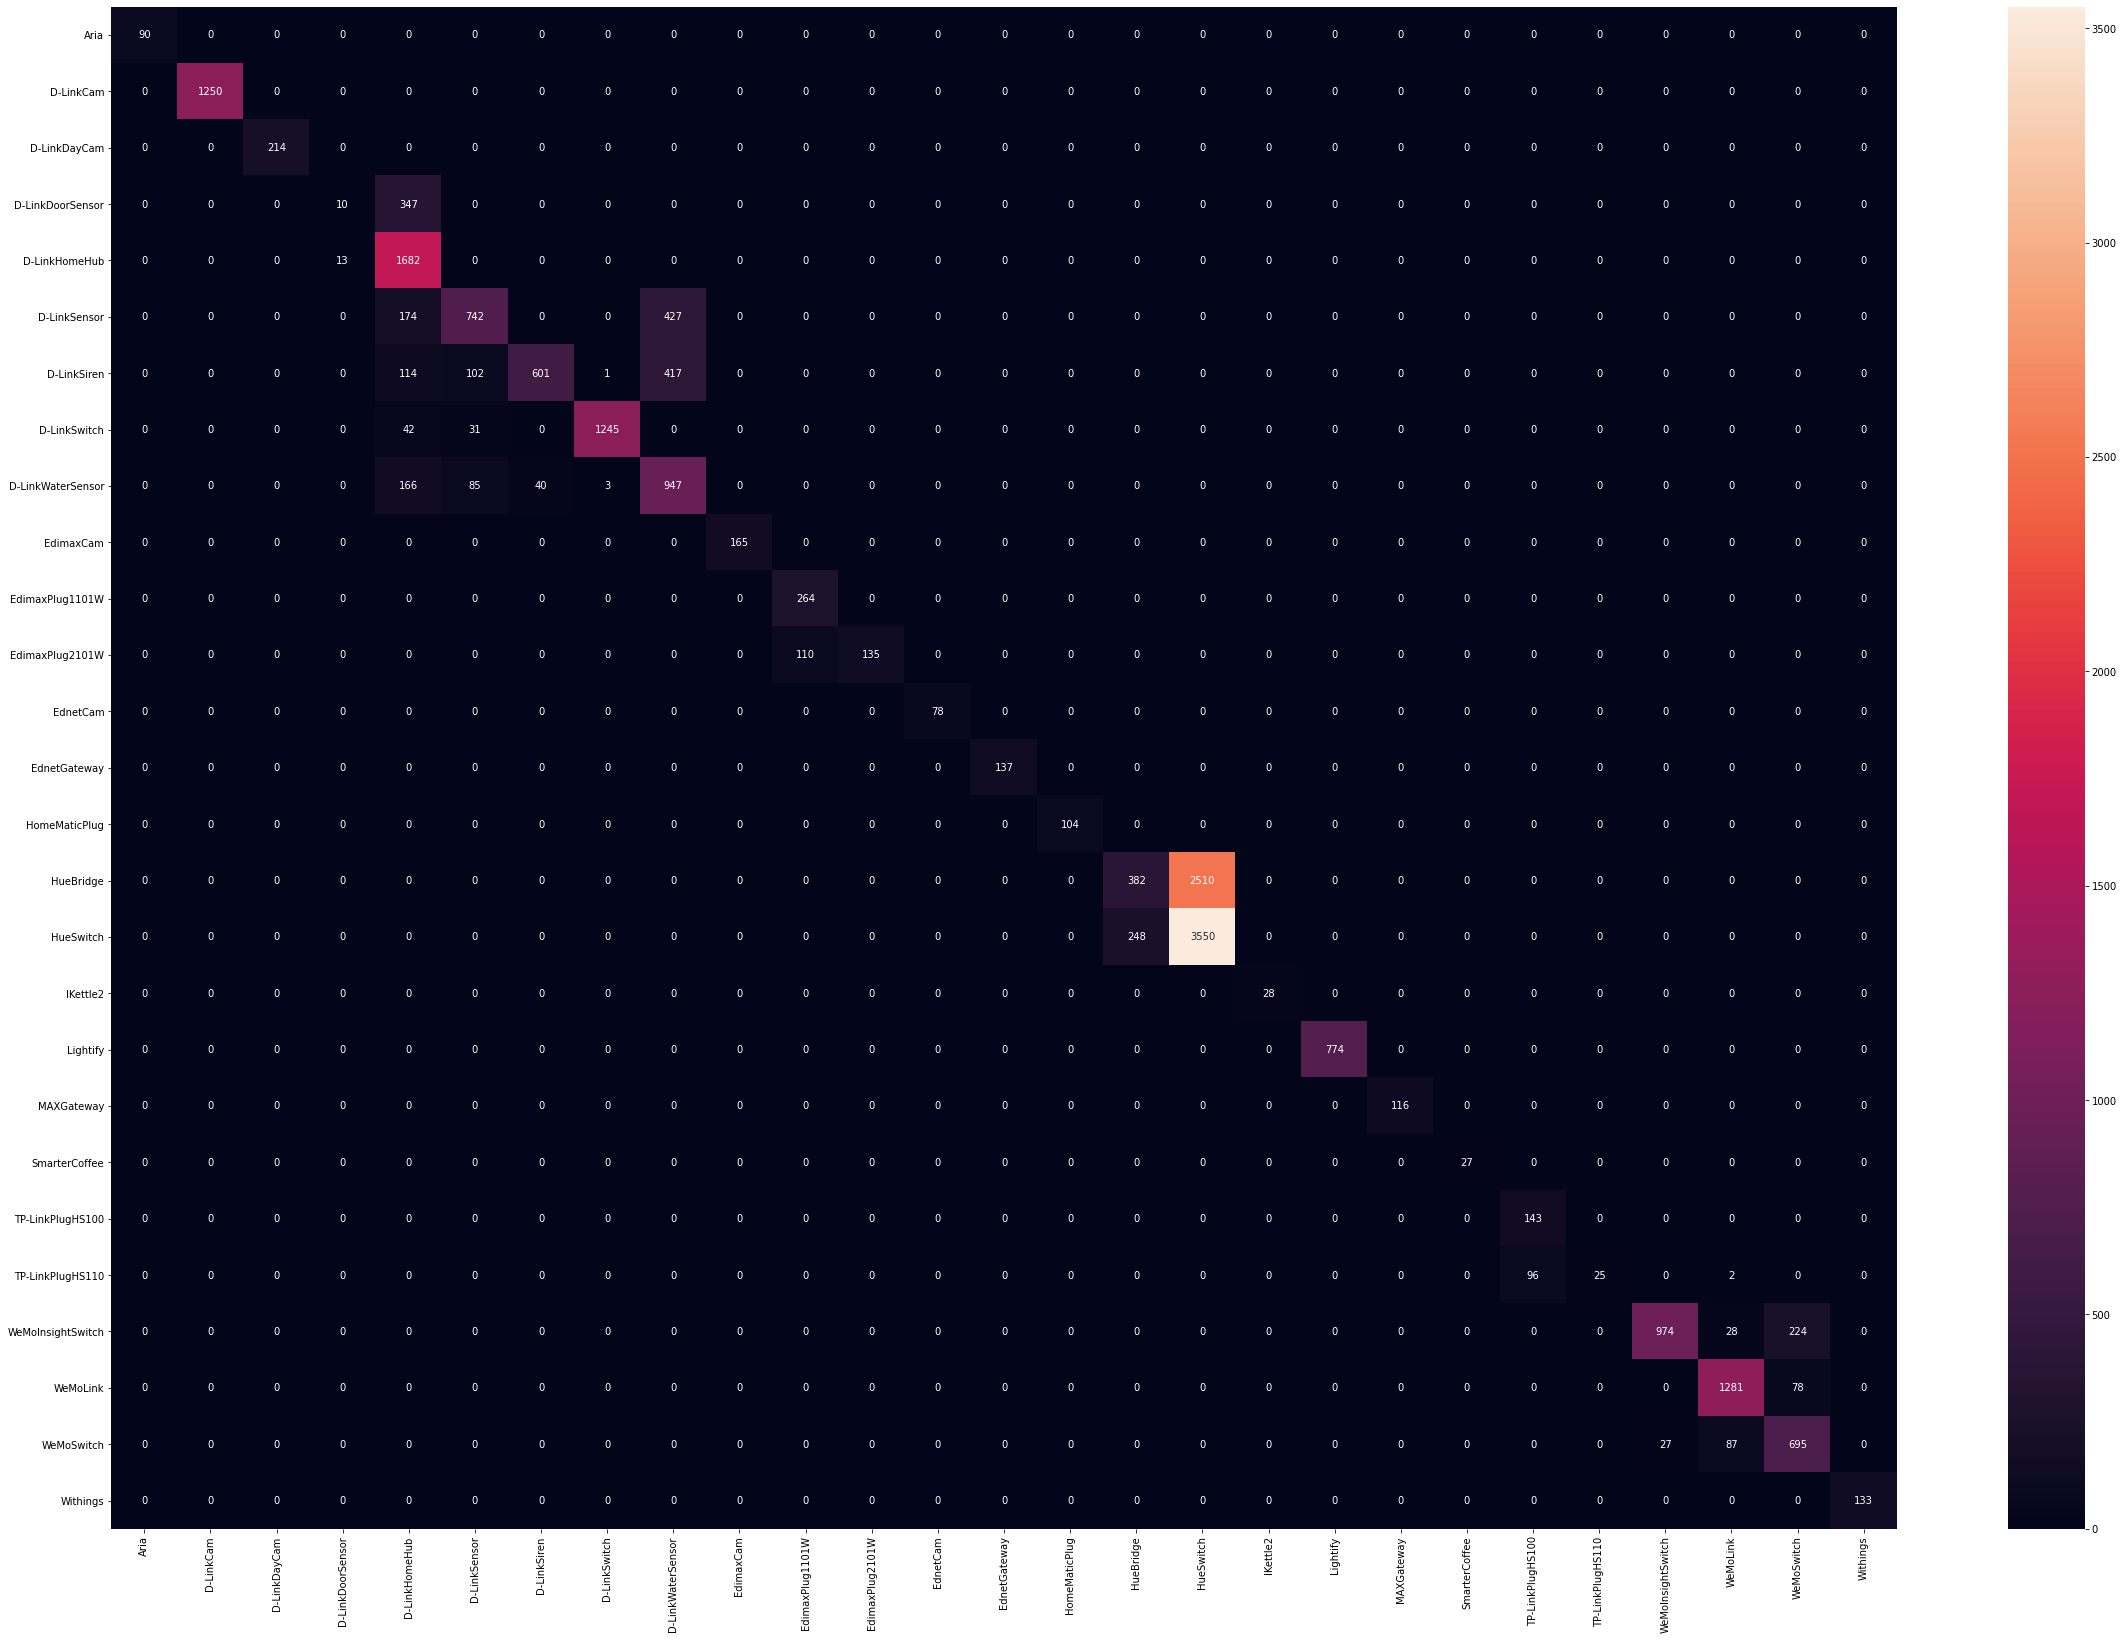

In [29]:
test='Aalto_test_IoTDevID.csv'
train='Aalto_train_IoTDevID.csv'



dataset="./Aalto/False/"
folder(dataset)

mixed=False
step=13
sayac=1
output_csv=dataset+str(sayac)+"_"+str(step)+"_"+str(mixed)+".csv"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step))   


# Mixed (Size 13)

Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
Aalto/False_13  0   1   DT      0.83  0.86  0.9   0.86  0.8551   0.82  0.21     0.01    0.22    0.21    
Aalto/False_13  1   2   DT      0.84  0.86  0.9   0.86  0.8566   0.82  0.2      0.01    0.2     0.2     
Aalto/False_13  2   3   DT      0.83  0.86  0.9   0.86  0.8552   0.82  0.29     0.01    0.3     0.28    
Aalto/False_13  3   4   DT      0.83  0.86  0.9   0.86  0.8625   0.82  0.29     0.01    0.3     0.2     
Aalto/False_13  4   5   DT      0.83  0.86  0.9   0.86  0.8529   0.82  0.24     0.02    0.26    0.26    
Aalto/False_13  5   6   DT      0.83  0.86  0.9   0.86  0.8581   0.82  0.2      0.0     0.2     0.23    
Aalto/False_13  6   7   DT      0.83  0.87  0.9   0.87  0.8647   0.82  0.25     0.01    0.26    0.21    
Aalto/False_13  7   8   DT      0.83  0.87  0.9   0.87  0.8646   0.82  0.26     0.0     0.26    0.25    
Aalto/False_13  8   9   DT      0.83  0.86  0.9   0.86 

Aalto/False_13  78  79  DT      0.83  0.86  0.9   0.86  0.8571   0.82  0.22     0.0     0.22    0.2     
Aalto/False_13  79  80  DT      0.83  0.87  0.9   0.87  0.8625   0.82  0.2      0.0     0.2     0.17    
Aalto/False_13  80  81  DT      0.83  0.86  0.9   0.86  0.8607   0.82  0.25     0.02    0.27    0.22    
Aalto/False_13  81  82  DT      0.83  0.86  0.9   0.86  0.8603   0.81  0.27     0.02    0.28    0.23    
Aalto/False_13  82  83  DT      0.83  0.86  0.9   0.86  0.8549   0.81  0.23     0.02    0.25    0.22    
Aalto/False_13  83  84  DT      0.84  0.87  0.9   0.87  0.8654   0.82  0.25     0.02    0.27    0.22    
Aalto/False_13  84  85  DT      0.83  0.86  0.9   0.86  0.863    0.81  0.2      0.02    0.22    0.22    
Aalto/False_13  85  86  DT      0.83  0.86  0.9   0.86  0.8615   0.81  0.23     0.0     0.23    0.23    
Aalto/False_13  86  87  DT      0.83  0.86  0.9   0.86  0.8565   0.82  0.2      0.02    0.22    0.27    
Aalto/False_13  87  88  DT      0.83  0.87  0.9   0.87 

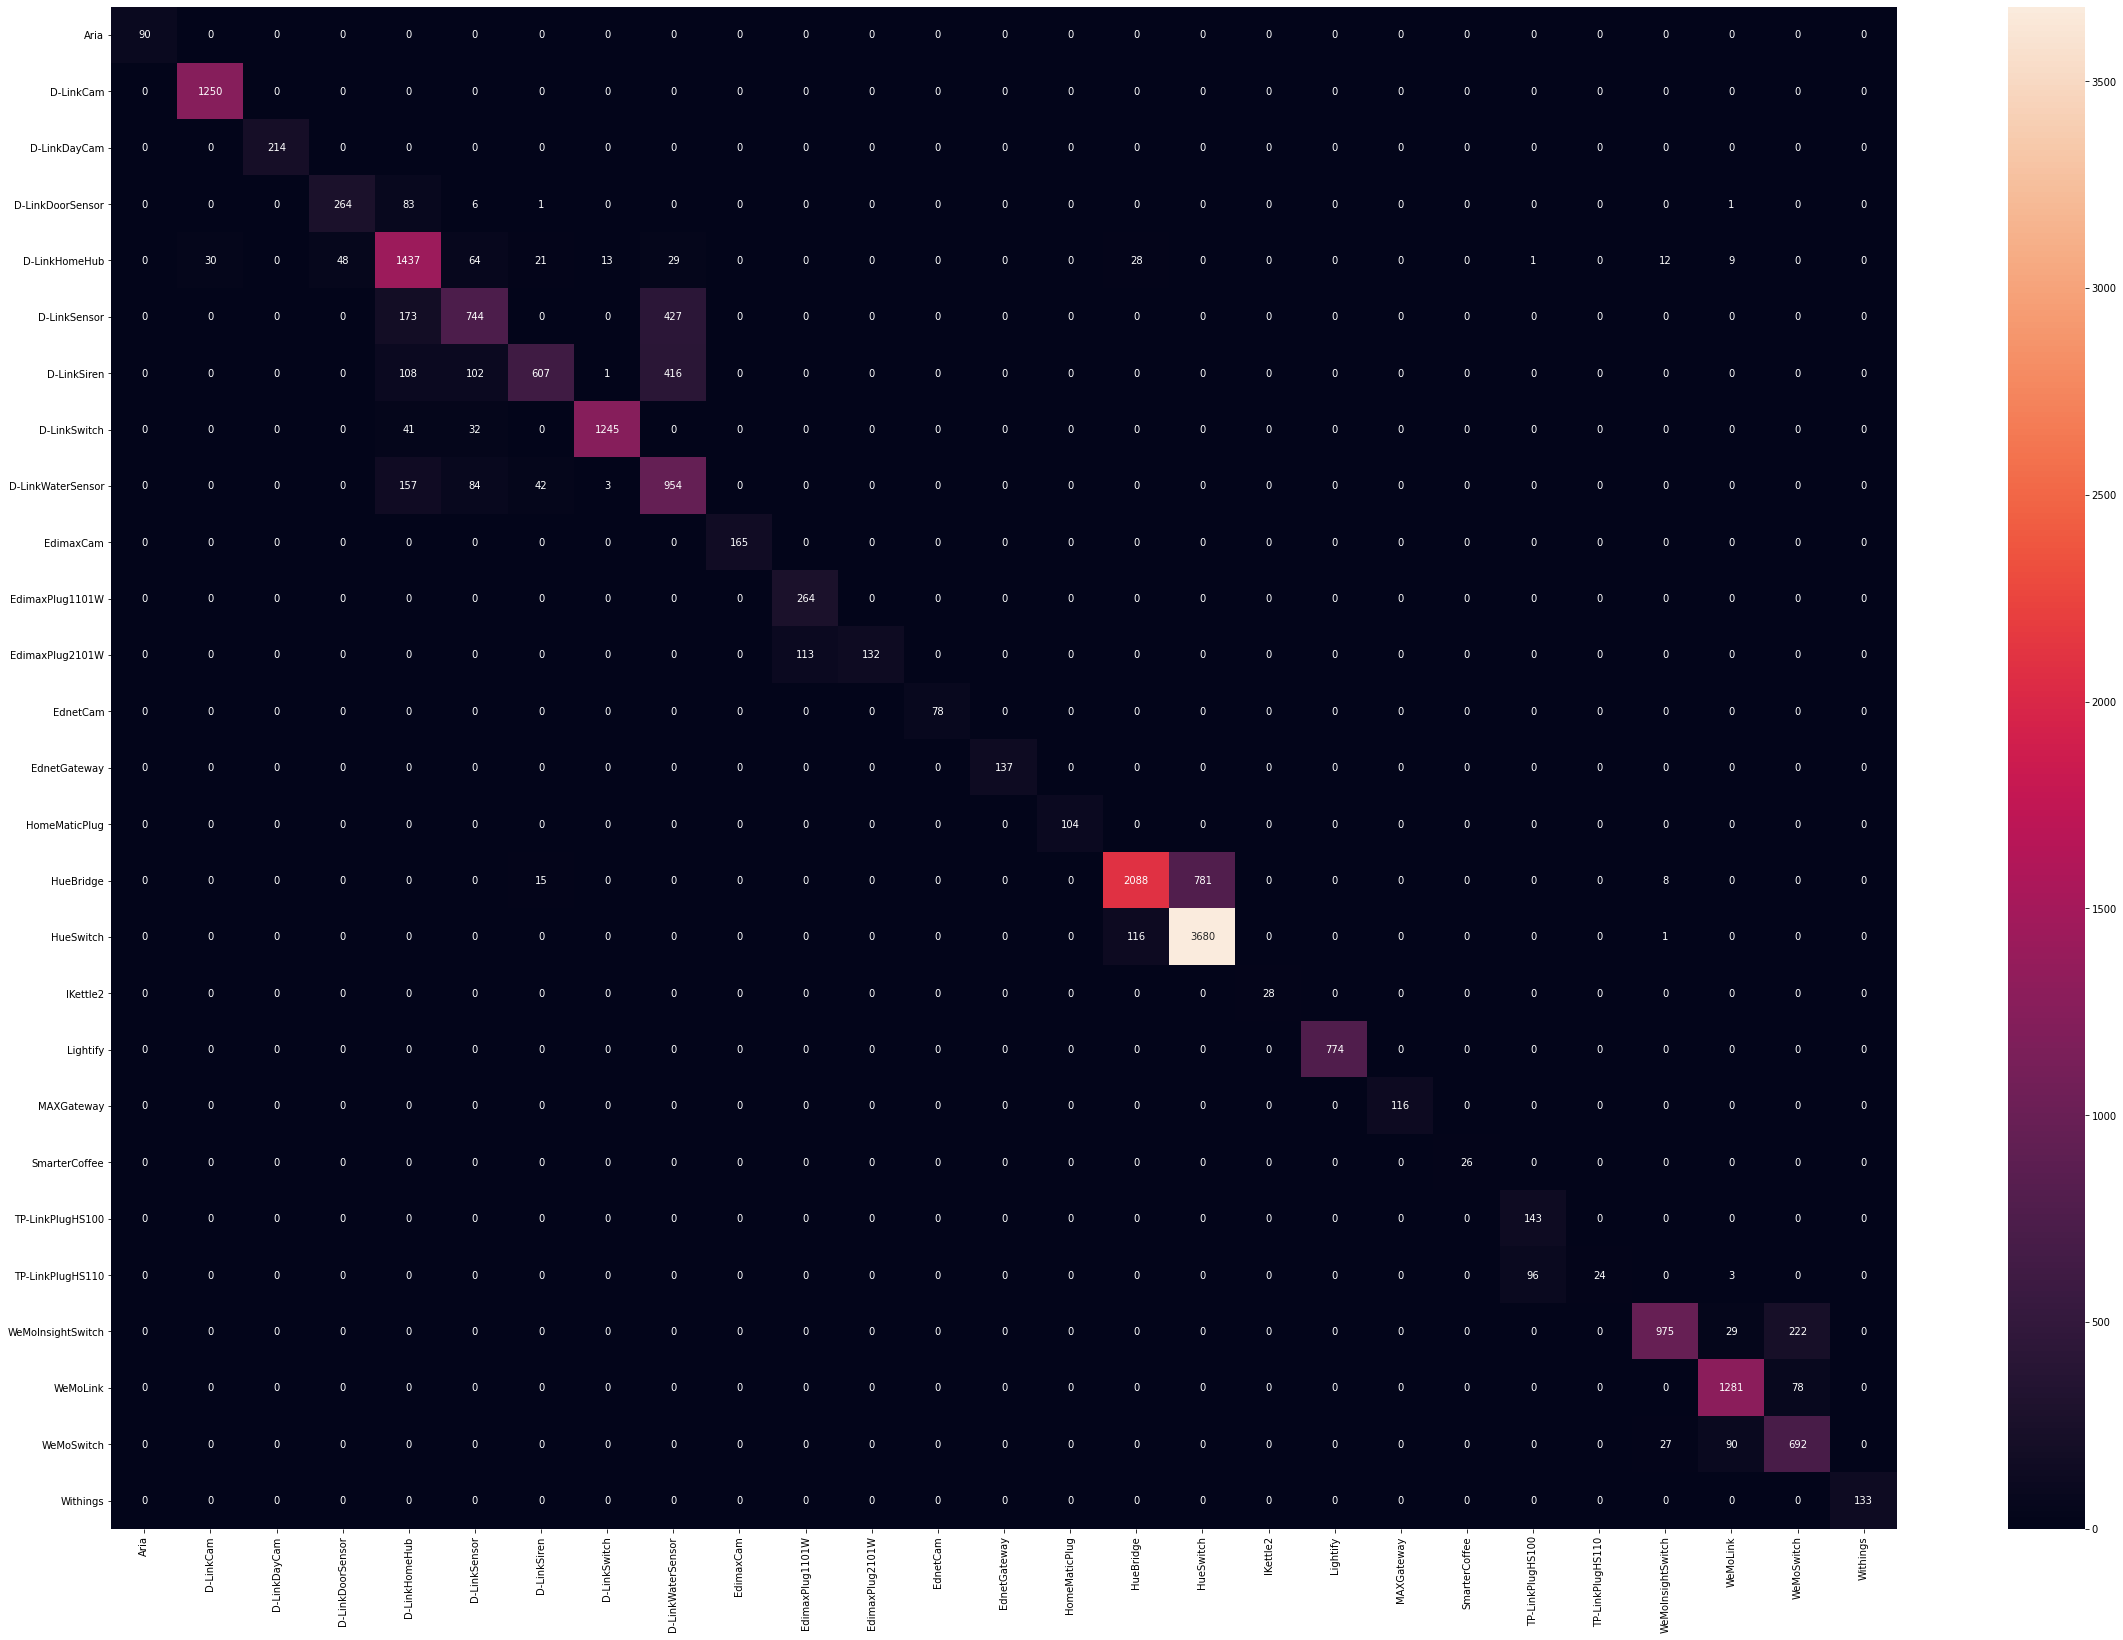

In [30]:
test='Aalto_test_IoTDevID.csv'
train='Aalto_train_IoTDevID.csv'



dataset="./Aalto/False/"
folder(dataset)

mixed=True
step=13
sayac=1
output_csv=dataset+str(sayac)+"_"+str(step)+"_"+str(mixed)+".csv"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step))   
